In [1]:
from matplotlib import pyplot as plt
import numpy as np
import struct
import scipy.constants as consts
import sys

In [2]:
plt.rcParams['figure.figsize'] = [12, 10]

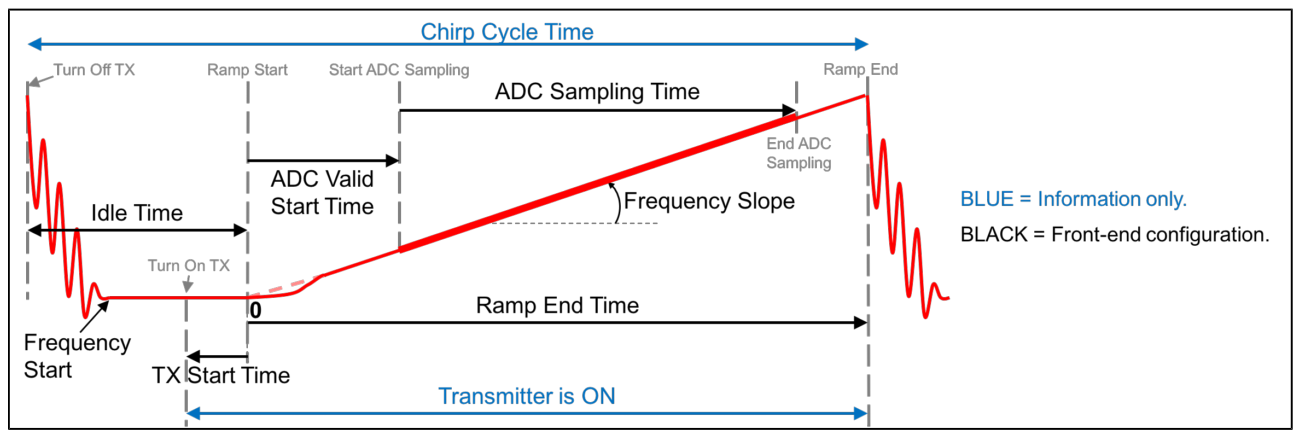

Config CLI
```
flushCfg
dfeDataOutputMode 1
channelCfg 15 1 0
adcCfg 2 1
lowPower 0 1
profileCfg 0 77 20 5 80 0 0  40 1 256 6000 0 0 30
chirpCfg 0 0 0 0 0 0 0 1
frameCfg 0 0 128 1024 20 1 0
testFmkCfg 0 0 0 1
setProfileCfg disable ADC disable
sensorStart

sensorStop
```

In [3]:
radarCfg = {'start_frequency': 77e9,
            'idle': 10e-6,
            'adcStartTime': 5e-6,
            'rampEndTime': 80e-6,
            'txStartTime': 1e-6,
            'adcSamples': 256,
            'adcSampleRate': 6000e3,
            'freqSlopeConst': 40e6/1e-6,
            'txPower': 0,
            'txPhaseShift': 0,
            'hpfCornerFreq1': 0,
            'hpfCornerFreq2': 0,
            'rxGain': 30,
            'numChirps': 128,
            'numLanes': 4,
            'isComplex': True,
           }

In [4]:
def make_profile_string(cfg):
    """IWR14xx CLI string:
    profileCfg <profileId> <startFreq> <idleTime> <adcStartTime> <rampEndTime> <txOutPower> <txPhaseShifter> <freqSlopeConst> <txStartTime> <numAdcSamples> <digOutSampleRate> <hpfCornerFreq1> <hpfCornerFreq2> <rxGain>
    
    profileId        - int
    startFreq        - float, GHz
    idleTime         - float, us
    adcStartTime     - float, us
    rampEndtime      - float, us
    txOutPower       - float, dB
    txPhaseShifter   - float
    freqSlopeConst   - float, Mhz/us
    txStartTime      - float, us
    numADCSamples    - int
    digOutSampleRate - int, kHz
    hpfCornerFreq1   - 0
    hpfCornerFreq2   - 0
    rxGain           - float, dB
    """
    profileStr = 'profileCfg {} {:.3f} {:.3f} {:.3f} {:.3f} {} {} {:.3f} {} {:.0f} {:.0f} {} {} {:.0f}'.format(
        0,
        cfg['start_frequency']/1e9,
        cfg['idle']/1e-6, 
        cfg['adcStartTime']/1e-6,
        cfg['rampEndTime']/1e-6,
        cfg['txPower'],
        cfg['txPhaseShift'],
        cfg['freqSlopeConst']/1e6*1e-6,
        cfg['txStartTime']/1e-6,
        cfg['adcSamples'],
        cfg['adcSampleRate']/1e3,
        cfg['hpfCornerFreq1'],
        cfg['hpfCornerFreq2'],
        cfg['rxGain']
    )
    return profileStr

def cmd_to_dict(cmd_str, curr_cfg = None):
    #TODO: implement others according to documentation
    cmd_split = cmd_str.split()
    
    if cmd_split[0] == 'profileCfg':
        curr_cfg = profileStr_to_dict(cmd_split[1:], curr_cfg)
    else:
        raise ValueError(f"Unknown command {cmd_split[0]}")
        
    return curr_cfg

def dict_to_cli(config):
    #TODO: implement
    pass
    
def profileStr_to_dict(args, curr_cfg = None):
    normalizer = [None, 1e9, 1e-6, 1e-6, 1e-6, None, None, 1, 1e-6, None, 1e3, None, None, None]
    dtype = [int, float, float, float, float, float, float, float, float, int, float, int, int, float]
    keys = ['id',
            'start_frequency',
            'idle',
            'adcStartTime',
            'rampEndTime',
            'txPower',
            'txPhaseShift',
            'freqSlopeConst',
            'txStartTime',
            'adcSamples',
            'adcSampleRate',
            'hpfCornerFreq1',
            'hpfCornerFreq2',
            'rxGain',
           ]
    if curr_cfg:
        cfg = curr_cfg
    else:
        cfg = {}
            
    for k, v, n, d in zip(keys, args, normalizer, dtype):
        cfg[k] = d(float(v) * n if n else v)
    return cfg

In [5]:
make_profile_string(radarCfg)

'profileCfg 0 77.000 10.000 5.000 80.000 0 0 40.000 1.0 256 6000 0 0 30'

In [6]:
_test = {}
_test['numChirps'] = 128
cmd_to_dict("profileCfg 0 77.000 10.000 5.000 80.000 0 0 40.000 1.0 256 6000 0 0 30", _test)

{'numChirps': 128,
 'id': 0,
 'start_frequency': 77000000000.0,
 'idle': 9.999999999999999e-06,
 'adcStartTime': 4.9999999999999996e-06,
 'rampEndTime': 7.999999999999999e-05,
 'txPower': 0.0,
 'txPhaseShift': 0.0,
 'freqSlopeConst': 40.0,
 'txStartTime': 1e-06,
 'adcSamples': 256,
 'adcSampleRate': 6000000.0,
 'hpfCornerFreq1': 0,
 'hpfCornerFreq2': 0,
 'rxGain': 30.0}

## Helper functions to get physical units

Everything is in SI units (metric)

In [7]:
def compute_interchirp_time(cfg):
    return cfg['idle']+cfg['rampEndTime']

def fft_bin2freq(fft_bin, cfg, fft_shift=False):
    #TODO: handle fftshift?
    return np.fft.fftfreq(cfg['adcSamples'], 1/cfg['adcSampleRate'])[fft_bin]

def freq2range(beat_freq, cfg):
    return beat_freq * consts.c/(2*cfg['freqSlopeConst'])

def fft_bin2range(fft_bin, cfg):
    return freq2range(fft_bin2freq(fft_bin, cfg), cfg)

def doppler_bin2velocity(doppler_bin, cfg, shifted=True):
    tc = compute_interchirp_time(cfg)
    lambd = consts.c/cfg['start_frequency']
    dv = lambd/(2*cfg['numChirps']*tc)
    v = np.arange(cfg['numChirps'])*dv
    if shifted:
        zero_idx = np.argmin(np.fft.fftshift(np.arange(cfg['numChirps'])))
        v -= v[zero_idx]
    return v[doppler_bin]

## IO Helper functions

`zeropad_missing_packets` limitations:
 - Currently only handles ADC mode correctly (i.e. no headers)
 - cannot handle out of order packets: (TODO: implement either reorder or discard)
 - Needs to know now to hand CP_ADC_CQ, CP_ADC modes. 

In [8]:
def read_raw_udp(filename, PACKET_LENGTH = 1466):
    with open(filename, 'rb') as raw_capture:
        packet_data = []
        for chunk in iter(lambda: raw_capture.read(PACKET_LENGTH), ''):
            if len(chunk) < PACKET_LENGTH:
                print('Remainder bytes: {}. Something is wrong if not 0'.format(len(chunk)))
                break
            else:
                packet_data.append(chunk)
        print('{} packets read.'.format(len(packet_data)))
    
    return packet_data

In [9]:
def zeropad_missing_packets(packet_data, config, verbose=True):
    #TODO: implement reorder
    seqn_ = 0
    bytec_ = 0
    samples = []

    numBytesPerFrame = 2*config['adcSamples']*config['numLanes']*config['numChirps']
    if config['isComplex']:
        numBytesPerFrame *= 2
    numSamplesPerFrame = numBytesPerFrame/2
    print("Bytes per frame: {}".format(numBytesPerFrame))
    packetsPerFrame = numBytesPerFrame/1456
    print("Packets per frame: {}".format(packetsPerFrame))

    for packet in packet_data:
        seqn, _b, bytec = struct.unpack('<III', packet[:12])
        if seqn_ +1 != seqn:
            packets_lost = seqn - seqn_
            bytes_lost = bytec - bytec_
            if verbose:
                print("@frame {}-{}: lost {} packets ({} bytes, {} samples, {:.3f} frames)".format(seqn_/packetsPerFrame,
                                                                                                   seqn/packetsPerFrame,
                                                                                                   packets_lost,
                                                                                                   bytes_lost,
                                                                                                   (bytes_lost)/2,
                                                                                                   bytes_lost/numBytesPerFrame
                                                                                                  ))

            samples.append(np.zeros((bytec-bytec_-1456)//2, dtype=np.int16))
        samples.append(np.frombuffer(packet[10:], dtype=np.int16))
        seqn_ = seqn
        bytec_ = bytec
    samples = np.concatenate(samples)
    print("Last seqn read {}, last bytecount {} + 1456".format(seqn, bytec))
    print("expected samples length {}".format((bytec + 1456)//2))
    print("Num samples {}".format(samples.shape))

    print("{} frames available:".format(samples.shape[0]/numSamplesPerFrame))
    
    return samples

In [10]:
def form_data_cube(config, flat_array):
    samples_per_frame = config['adcSamples'] * config['numChirps'] * config['numLanes']
    if config['isComplex']:
        data = flat_array.reshape(-1, 8)
        data = data[:, :4] + 1j* data[:, 4:]
        data.reshape(-1)
    else:
        data = flat_array
        
    samples_to_discard = len(data)%samples_per_frame
    
    if samples_to_discard >0:
        print("Warning: there seems to be incomplete frames. {} samples discarded.".format(samples_to_discard))
        data = data[:-samples_to_discard]
    
    return data.reshape(-1, config['numChirps'], config['adcSamples'], config['numLanes'])


In [11]:
packet_data = read_raw_udp('test/adc_data_Raw_0.bin', 1470)
samples = zeropad_missing_packets(packet_data, radarCfg)

Remainder bytes: 62. Something is wrong if not 0
183778 packets read.
Bytes per frame: 524288
Packets per frame: 360.0879120879121
@frame 0.063873291015625-1.9467468261718748: lost 678 packets (987168 bytes, 493584.0 samples, 1.883 frames)
Last seqn read 184455, last bytecount 268565024 + 1456
expected samples length 134283240
Num samples (134283240,)
512.2499084472656 frames available:


In [12]:
for i in range(10):
    print(struct.unpack('<IIIh'+('i'*4), packet_data[i][:14 + 8*2]))

(1, 1456, 0, 0, -68026466, -11665624, -56360704, -38666806)
(2, 1456, 1456, 0, -14876812, 14876299, -8060771, -2621870)
(3, 1456, 2912, 0, -25952675, 1966024, -14811303, -27984395)
(4, 1456, 4368, 0, -7668007, 3866421, -10879077, -4260408)
(5, 1456, 5824, 0, -36896661, -19726874, -5570034, -35389636)
(6, 1456, 7280, 0, -43974945, -29098798, -1375737, -45613615)
(7, 1456, 8736, 0, -46727620, -4456458, -26411281, -35520975)
(8, 1456, 10192, 0, -33096012, -42271246, 25231668, -63111692)
(9, 1456, 11648, 0, -15990929, -18809157, -4915156, -41681348)
(10, 1456, 13104, 0, -40829103, -40174235, 3342584, -63046279)


In [13]:
radar_data_cube = form_data_cube(radarCfg, samples)

## Plotting functions

In [2]:
def plot_range_time(dataarray, frame_n, rx_n, cfg=None):
    #if cfg is provided, convert to metric units
    rt_fft = np.fft.fft(dataarray[frame_n, :, :, rx_n])
    
    plt.figure()
    range_max = fft_bin2range(rt_fft.shape[1]//2-1, cfg) if cfg else rt_fft.shape[1]
    plt.imshow(np.abs(rt_fft[:, :rt_fft.shape[1]//2]),
               interpolation='nearest',
               extent=(0, range_max, 0, rt_fft.shape[0]),
               aspect=range_max/(5*rt_fft.shape[0]),
               origin='lower'
              )
    plt.title('Chirp(Time)/Range')
    plt.show()
    return rt_fft

def plot_doppler_range(dataarray, frame_n, rx_n, cfg=None):
    rt_fft = np.fft.fft(dataarray[frame_n, :, :, rx_n])
    dr_fft = np.fft.fftshift(np.fft.fft(rt_fft, axis=0), axes=0)
    
    plt.figure()
    range_max = fft_bin2range(rt_fft.shape[1]//2-1, cfg) if cfg else rt_fft.shape[1]
    v_min = doppler_bin2velocity(0, cfg)
    v_max = doppler_bin2velocity(cfg['numChirps']-1, cfg)
    plt.imshow(np.abs(dr_fft[:, :rt_fft.shape[1]//2]),
               interpolation='nearest',
               extent=(0, range_max, v_min, v_max),
               aspect=range_max/(v_max-v_min),
               origin='lower'
              )
    plt.title('Dopper/Range')
    plt.show()
    return dr_fft

def plot_range_azimuth(dataarray, frame_n, chirp_n, cfg=None):
    rt_fft = np.fft.fft(dataarray[frame_n, :, :, :], axis=1)
    dr_fft = np.fft.fftshift(np.fft.fft(rt_fft, axis=0), axes=0)
    azi_fft = np.fft.fftshift(np.fft.fft(dr_fft, axis=2), axes=2)
    
    plt.figure()
    
    range_max = fft_bin2range(rt_fft.shape[1]//2-1, cfg) if cfg else rt_fft.shape[1]
    
    plt.imshow(np.abs(azi_fft[chirp_n, :rt_fft.shape[1]//2, :]),
               interpolation='nearest', 
               extent=(-np.pi/2, np.pi/2, 0, fft_bin2range(127, radarCfg)),
               aspect=np.pi/range_max,
               origin='lower'
              )
    plt.title('Range/Azimuth(rad)')
    return azi_fft

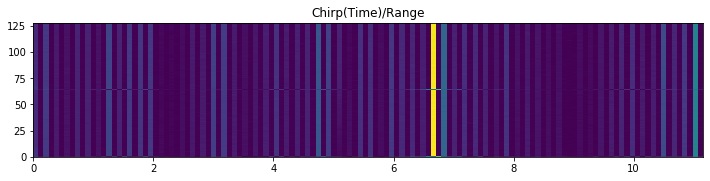

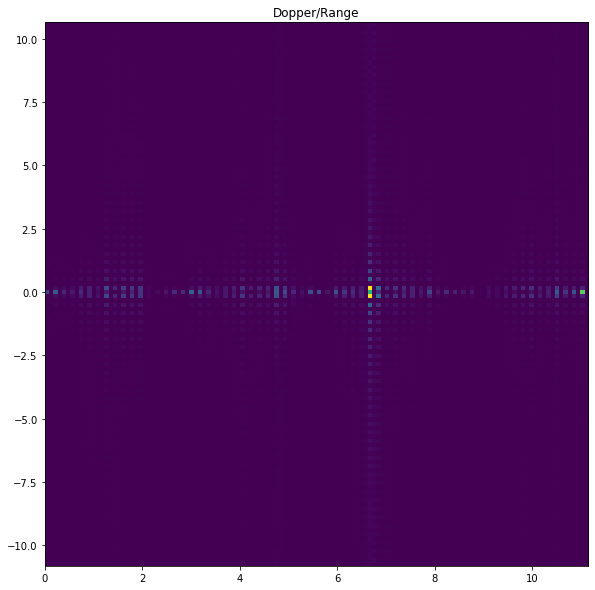

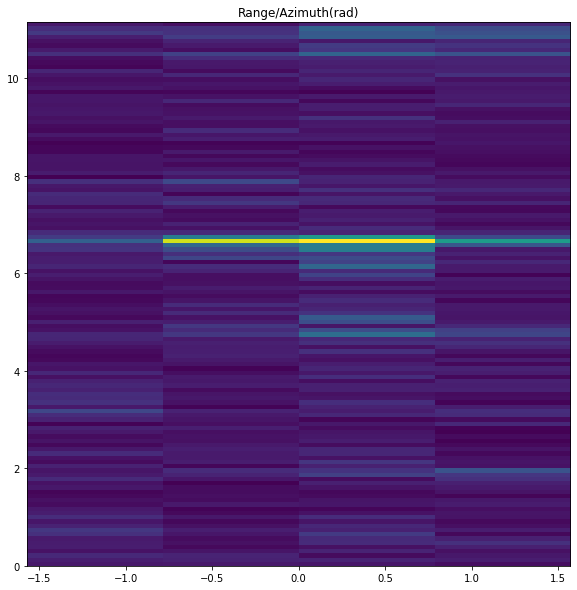

In [15]:
range_fft = plot_range_time(radar_data_cube, 10, 0, radarCfg)
doppler_fft = plot_doppler_range(radar_data_cube, 10, 0, radarCfg)
azi_fft = plot_range_azimuth(radar_data_cube, 10, 0, radarCfg)

## Verify with binary generated by `Packet_Reorder_Zerofill.exe`

In [16]:
samples2 = np.fromfile('test/adc_data_test5.bin', dtype='int16',  )

In [17]:
radarCfg2 =  radarCfg.copy()
radarCfg2['adcSamples'] = 256
radarCfg2['isComplex'] = False
radarCfg2['numLanes'] = 4
radarCfg2

{'start_frequency': 77000000000.0,
 'idle': 1e-05,
 'adcStartTime': 5e-06,
 'rampEndTime': 8e-05,
 'txStartTime': 1e-06,
 'adcSamples': 256,
 'adcSampleRate': 6000000.0,
 'freqSlopeConst': 40000000000000.0,
 'txPower': 0,
 'txPhaseShift': 0,
 'hpfCornerFreq1': 0,
 'hpfCornerFreq2': 0,
 'rxGain': 30,
 'numChirps': 128,
 'numLanes': 4,
 'isComplex': False}

In [18]:
radar_data2 = form_data_cube(radarCfg2, samples2)
print(radar_data2.shape)

(1024, 128, 256, 4)


(128, 256, 4)


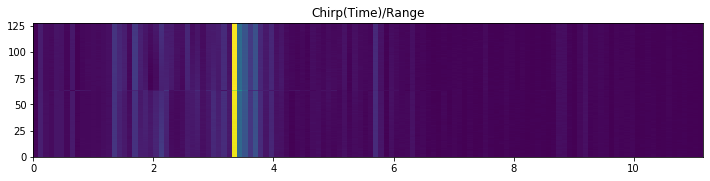

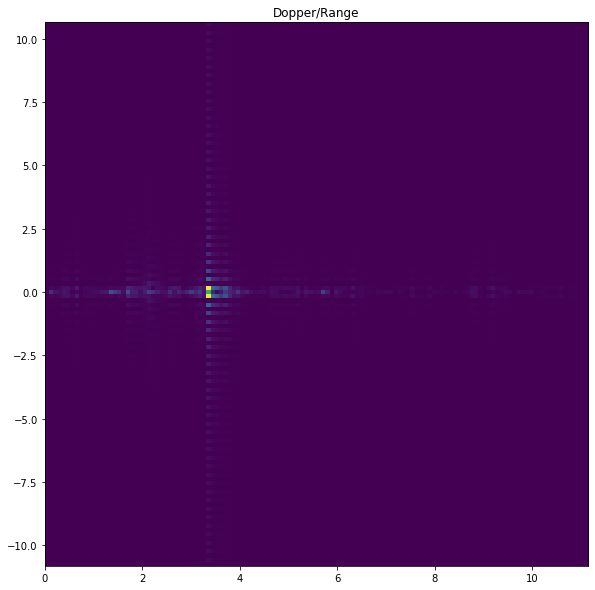

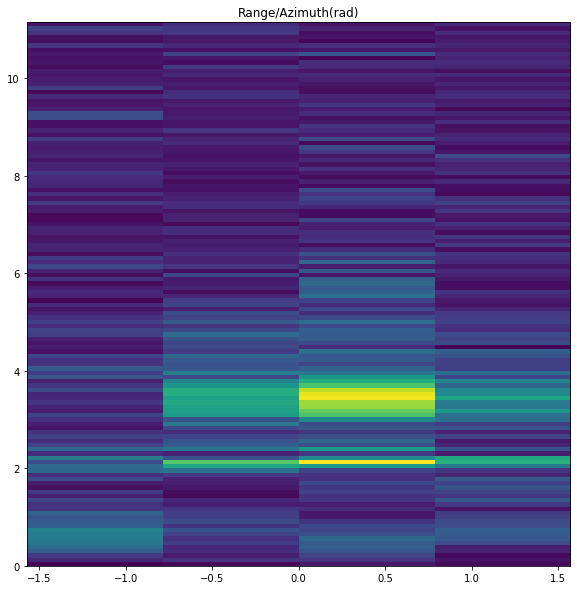

In [19]:
f0_rx0 = radar_data2[1023, :, :, :]
print(f0_rx0.shape)

range_fft = plot_range_time(radar_data2, 1023, 0, radarCfg2)
doppler_fft = plot_doppler_range(radar_data2, 1023, 0, radarCfg2)
azi_fft = plot_range_azimuth(radar_data2, 1023, 0, radarCfg2)

# Dummy data
Check if we are doing the right thing

In [20]:
#uncorrelated noise
sim_sig = np.random.uniform(high=.01, low=-.01, size=[128, 256])

tt = np.arange(256)*(1/6000e3)
#IF 1 @ 500hz , phase shift 0.01 rad phase per chirp
if1 = np.array([np.sin( 2* np.pi * 500000 * tt + 0.4 * n) for n in range(128)])

#IF 2 @ 500hz , phase shift -0.01 rad phase per chirp
if2 = np.array([np.sin( 2* np.pi * 500000 * tt + 0.9 * n) for n in range(128)])

#IF 3 @ 1500hz , phase shift -0.02 rad phase per chirp
if3 = np.array([np.sin( 2* np.pi * 150000 * tt - 0.2 * n) for n in range(128)])


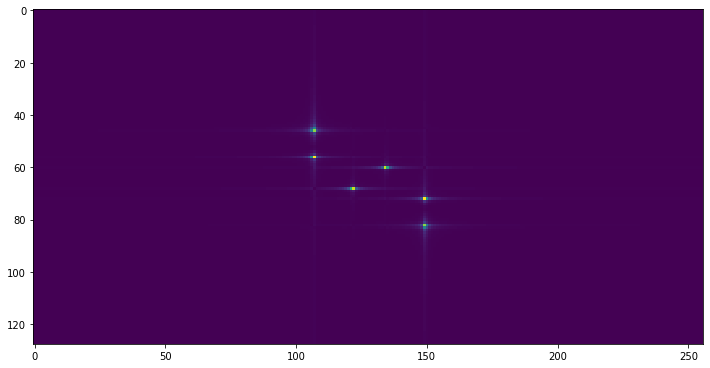

In [21]:
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(sim_sig+if1+if2+if3))))